The original data was given in the form of text files, but I wrote a script to tabulate it in a csv file that can easily be read into a DataFrame. That boilerplate code is omitted, but the csv files themselves clearly denote the features provided. In the following walkthrough, `data` is the training data (itself split for cross-validation until the very end), `test` is the test data (not used at all in model development), `labels` is the training data classes, and `answers` is the test data classes.

Also, this walkthrough does NOT use any of the time-series data provided, only the discrete feature vectors. As you will see, we achieve a respectable accuracy even with this subset of the data.

In [165]:
import pandas as pd
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data.pop('Unnamed: 0')
test.pop('Unnamed: 0')

labels = data.pop('class')
answers = test.pop('class')
data.head()

Before testing different models, we create a helper method that automatically cross-validates a model given the data, model itself, and number of folds.

In [47]:
%%capture
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier

#first we set up a training/scoring function that will be used in the future also
#it uses K-fold cross-validation to more accurately estimate training error
def kfold_test(k = 10, model = AdaBoostClassifier(), data = None, labels = None):
    
    kf = KFold(n_splits = k)
    score = []
    
    for train,test in kf.split(data):

        #get labels
        train_y = labels[train]
        test_y = labels[test]

        #train with provided model
        model.fit(data.iloc[train], train_y)

        #calculate score
        score.append(model.score(data.iloc[test], test_y))
    
    average_error = sum(score)*1.0/len(score)
    return average_error

Now let's try a _really_ naive approach: just use basic algorithms on all 561 features. It will probably fail miserably, but we'll at least get a baseline, and a feel for which base classifiers we should even attempt to tune. 

In [167]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 20)
kfold_test(10, knn, data, labels)

0.8989407719609582

In [77]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
kfold_test(10, logr, data, labels)

0.9412420511682933

In [48]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
kfold_test(10, nb, data, labels)

0.6897376885536823

In [99]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
kfold_test(10, svc, data, labels)

0.8970354554865423

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
kfold_test(10, dt, data, labels)

0.8446657793552204


In [15]:
ada = AdaBoostClassifier()
kfold_test(10, ada, data, labels)

0.5467912599822539

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
kfold_test(10, rf, data, labels)

0.8962204229517894


In [35]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
kfold_test(10, nn, data, labels)

0.922604074238391

Now that we have a decent set of baselines, the next step should be to start pruning features to see how that affects the accuracies of the above naive models. The first step should be to get rid of all features that have very low variance, those that don't change enough across samples to be useful in training. We also choose to abandon AdaBoost since it performs so poorly.

In [168]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest

k = 100
select = SelectKBest(k=k)
select.fit(data, labels)

ranked = list(zip(data.columns, select.scores_))
ranked.sort(key = itemgetter(1))
ranked.reverse()

for (ranked, score) in ranked[:10]:
    print("%-50s %.2f" % (ranked, score))

367 fBodyAccJerk-entropy()-X                       36918.10
41 tGravityAcc-mean()-X                            29362.64
53 tGravityAcc-min()-X                             28175.40
368 fBodyAccJerk-entropy()-Y                       28115.92
50 tGravityAcc-max()-X                             26686.80
57 tGravityAcc-energy()-X                          25981.56
524 fBodyBodyAccJerkMag-entropy()                  23619.25
235 tBodyAccJerkMag-entropy()                      23437.11
288 fBodyAcc-entropy()-X                           23221.61
103 tBodyAccJerk-entropy()-X                       22267.09


In [79]:
data_k = pd.DataFrame(select.transform(data))
models = [('knn', KNeighborsClassifier(n_neighbors=20)), ('logr', LogisticRegression()), ('nb', GaussianNB()),
         ('svc', SVC(kernel='linear')), ('dt', DecisionTreeClassifier()), ('rf', RandomForestClassifier()), 
         ('mlp', MLPClassifier())]

for name, model in models:
    print(name + ": " + str(kfold_test(10, model, data_k, labels)))

knn: 0.8756848935226266
logr: 0.9071081041112097
nb: 0.765232179828453
svc: 0.8769114167406092
dt: 0.8139250591540964
rf: 0.8554161120970127
mlp: 0.8835775288376219


So it seems that selecting just the top K features increases error slightly, but that at least tells us that a fraction of the features are responsible for most of the learning that takes place. The next step is to weed out correlated features and try again. We borrowed code from https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/ to save time. We remove feature pairs with at least 0.8 correlation. This should make the feature set less cluttered.

In [169]:
correlated_features = set()  
correlation_matrix = data.corr()

for i in range(len(correlation_matrix .columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('number of correlated features: ' + str(len(correlated_features)))
data_pruned = data.drop(labels=correlated_features, axis=1)
data_pruned.head()

number of correlated features: 416


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,"26 tBodyAcc-arCoeff()-X,1","29 tBodyAcc-arCoeff()-X,4","30 tBodyAcc-arCoeff()-Y,1","32 tBodyAcc-arCoeff()-Y,3","33 tBodyAcc-arCoeff()-Y,4","34 tBodyAcc-arCoeff()-Z,1",...,533 fBodyBodyGyroMag-min(),538 fBodyBodyGyroMag-maxInds,540 fBodyBodyGyroMag-skewness(),551 fBodyBodyGyroJerkMag-maxInds,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,0.929294,-0.058526,0.256892,0.264106,-0.095246,0.278851,...,-0.989498,-1.000000,0.586156,-1.000000,-0.074323,-0.298676,-0.112754,0.030400,-0.464761,-0.018446
1,0.278419,-0.016411,-0.123520,-0.998245,0.611627,0.284595,0.115705,0.294310,-0.281211,0.085988,...,-0.991829,-0.948718,-0.336310,-1.000000,0.158075,-0.595051,0.053477,-0.007435,-0.732626,0.703511
2,0.279653,-0.019467,-0.113462,-0.995380,0.273025,-0.164739,0.017150,0.342256,-0.332564,0.239281,...,-0.995703,-0.794872,-0.535352,-0.555556,0.414503,-0.390748,-0.118559,0.177899,0.100699,0.808529
3,0.279174,-0.026201,-0.123283,-0.996091,0.061436,-0.264307,0.072545,0.323154,-0.170813,0.294938,...,-0.996199,-1.000000,-0.230091,-0.936508,0.404573,-0.117290,-0.036788,-0.012892,0.640011,-0.485366
4,0.276629,-0.016570,-0.115362,-0.998139,0.313276,0.086904,0.257615,0.434728,-0.315375,0.439744,...,-0.998353,-0.897436,-0.510282,-0.936508,0.087753,-0.351471,0.123320,0.122542,0.693578,-0.615971


416/561 features seem to be correlated with each other, a significant number. We remove all of those features and rerun the list of models we created earlier to see how accuracy is affected.

In [122]:
for name, model in models:
    print(name + ": " + str(kfold_test(10, model, data_pruned, labels)))

knn: 0.8669763013901213
logr: 0.9283176205264715
nb: 0.82997892635315
svc: 0.9179813664596272
dt: 0.8411305826678499
rf: 0.888879769299024
mlp: 0.9224682046731736


These results show a marked improvement in comparison to K-best and are similar to those obtained with all the features. Thus, we conclude that our correlation matrix strategy does indeed isolate the subset of features that are most important to learn. From now on we focus on tuning the following models since they're the most promising:
* Logistic regression
* Support vector machine
* Multilayer perceptron

Since we're training fewer models, we can even iterate through many values of k and graph the accuracies of each model for each value of k.

In [84]:
logr_acc = []
svc_acc = []
mlp_acc = []

#try values of k = 10,20,30,...,100
for k in range(10,110,10):
    select = SelectKBest(k=k)
    select.fit(data_pruned, labels)
    
    #get rid of all but the top k features
    data_k = pd.DataFrame(select.transform(data_pruned))
    logr_acc.append(kfold_test(10, LogisticRegression(), data_k, labels))
    svc_acc.append(kfold_test(10, SVC(kernel='linear'), data_k, labels))
    mlp_acc.append(kfold_test(10, MLPClassifier(), data_k, labels))
    print('finished k = ' + str(k))

finished k = 10
finished k = 20
finished k = 30
finished k = 40
finished k = 50
finished k = 60
finished k = 70
finished k = 80
finished k = 90
finished k = 100


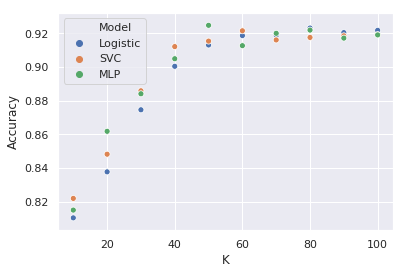

In [93]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

k_col = []
model_col = []
accuracy_col = []

for i in range(10):
    k_col.append(10*(i+1))
    model_col.append('Logistic')
    accuracy_col.append(logr_acc[i])
    
    k_col.append(10*(i+1))
    model_col.append('SVC')
    accuracy_col.append(svc_acc[i])
    
    k_col.append(10*(i+1))
    model_col.append('MLP')
    accuracy_col.append(mlp_acc[i])

graph_data = pd.DataFrame()
graph_data['K'] = k_col
graph_data['Accuracy'] = accuracy_col
graph_data['Model'] = model_col
sns.scatterplot(x='K', y='Accuracy', hue='Model', data=graph_data)    

From the above graph, we can say that k = 80 is a safe choice. Thus, we have successfully pruned our feature set from 561 to 80. RFECV ended up increasing error, so that trial is omitted here. All 3 selected models perform very well with 80 features, as shown below.

In [134]:
#first save the data using top 80 features (all other features discarded from now on)
select = SelectKBest(k=80)
select = select.fit(data_pruned, labels)

ranked = list(zip(data_pruned.columns, select.scores_))
ranked.sort(key = itemgetter(1))
ranked.reverse()

data_80 = pd.DataFrame()
for (feature, score) in ranked[:80]:
    data_80[feature] = data_pruned[feature] 

print('data_80 shape: ' + str(data_80.shape))

data_80 shape: (7352, 80)


In [140]:
print('final data: ' + str(data_final.shape))
print('logr: ' + str(kfold_test(10, LogisticRegression(), data_80, labels)))
print('svc: ' + str(kfold_test(10, SVC(kernel='linear'), data_80, labels)))
print('mlp: ' + str(kfold_test(10, MLPClassifier(), data_80, labels)))

final data: (7352, 79)
logr: 0.9230157497781721
svc: 0.9213829118603964
mlp: 0.9160760499852113


In [ ]:
from sklearn.ensemble import VotingClassifier

#create a voting classifier with our 3 top models
models = [('logr', LogisticRegression()), ('svc', SVC(kernel='linear')), ('mlp', MLPClassifier())]
vote = VotingClassifier(estimators=models)
kfold_test(10, vote, data_80, labels)

Now that we have settled on our 3 best models and a good feature subset, it is time to tune the hyperparameters in the 3 models using GridSearch. This should hopefully increase our accuracy a bit.

In [139]:
from sklearn.model_selection import GridSearchCV

logr = LogisticRegression()
params = {'fit_intercept': (True, False), 'warm_start':(True, False)}
search = GridSearchCV(logr, params, cv=5)
search.fit(data_80, labels)

print('logr best score: ' + str(search.best_score_))
print(search.best_params_)

logr best score: 0.919885745375408
{'fit_intercept': False, 'warm_start': True}


In [141]:
svc = SVC(kernel='linear')
params = {'shrinking':(True, False), 'probability':(True, False)}
search = GridSearchCV(svc, params, cv=5)
search.fit(data_80, labels)

print('svc best score: ' + str(search.best_score_))
print(search.best_params_)

svc best score: 0.919069640914037
{'probability': True, 'shrinking': True}


In [142]:
mlp = MLPClassifier()
params = {'activation':('identity', 'logistic', 'tanh', 'relu'), 'warm_start':(True, False)}
search = GridSearchCV(mlp, params, cv=5)
search.fit(data_80, labels)

print('mlp best score: ' + str(search.best_score_))
print(search.best_params_)

mlp best score: 0.9205658324265505
{'activation': 'relu', 'warm_start': False}


In [163]:
#now we rerun the voting classifier with the optimized parameters
models = [('logr', LogisticRegression(fit_intercept=False, warm_start=True)), 
          ('svc', SVC(kernel='linear', probability=True, shrinking=True)), 
          ('mlp', MLPClassifier(activation='relu', warm_start=False))]
vote = VotingClassifier(estimators=models)
kfold_test(10, vote, data_80, labels)

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

0.9258721532091098

Now is the moment of truth: we train our model on the entire training dataset and assess its accuracy on the test dataset. The use of 3 very different algorithms in a voting ensemble should somewhat combat overfitting.

In [166]:
vote = VotingClassifier(estimators=models)
vote.fit(data, labels)
vote.score(test, answers)

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9609772650152698